# Appendix - Code Assisting Main Project

## README

### Overview

This notebook includes all the auxiliary scripts that help the main modeling notebooks. 

### Contents

- **Load Mesh Grids and Administrative Boundaries**
   - Read mesh grids for cities (e.g., Addis Ababa, Baghdad)
   - Reproject boundaries and mesh grids to a common CRS.

- **Land Use Processing**
   - Extract land use polygons (e.g., farmland, residential, industrial)
   - Compute total area for each land use class within grid cells

- **POI & Infrastructure Processing**
   - Count the number of POIs per mesh cell (e.g., schools, hospitals)
   - Count fossil fuel power plants within grid cells

- **Process EDGAR Data**
   - Process the EDGAR Data and select data within interested area and time span.

- **Data Format Change**
   - Change files from *.gpkg* to *.csv*.


## 0 Initial Run

Run the following cell every time you start a new kernel to configure related parameters.

In [1]:
# Configuration
from pathlib import Path
import sys

CURR_PATH = Path().resolve()            # current file path
REPO_PATH = CURR_PATH.parent            # current repository path
DATA_PATH = REPO_PATH / "data"          # path for saving the data
DEMO_PATH = DATA_PATH / "demo-data"     # path for demo purpose 

SRC_PATH = REPO_PATH / "src"    # path for other sources
sys.path.append(str(SRC_PATH))  # add src to system path to import custom functions


## 1 Data Download

### 1.1 NO2 Data Download 

In this section, NO2 pollution data from [Google Earth Engine Sentinel 5P](https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S5P_NRTI_L3_NO2) is downloaded, for both Ethiopia and Iraq in country level.

From related literature and data quality, we finally decided to use **NO2_column_number_density** as the proxy for NO2 concentration level.

#### 1) Custom Functions

Custom function to generate desired time period of NOx data.

In [ ]:
import pandas as pd
from typing import List

import ee
ee.Authenticate() # For the first Initialization, individual API is needed to log into Google Earth Engine
ee.Initialize()

# Function: generate desired time period of NO2 data  
def specific_date(start_date: str, end_date: str, time_resolution: str = 'D') -> List[str]:
    """
    Generate a list of dates within specified time period and resolution.

    Parameters:
    - start_date: str
        Start date, format: 'YYYY-MM-DD'.
    - end_date: str
        End date, format: 'YYYY-MM-DD'.
    - time_resolution: str
        Time resolution (e.g., 'D' for daily, 'W' for weekly, 'M' for monthly). Default is 'D'.
    
    Return:
    - dates(list): List of date strings marking the ends of each time segment, format: 'YYYY-MM-DD'.
    
    """
    dates = (
        pd.date_range(start_date, end_date, freq = time_resolution)
        .strftime('%Y-%m-%d')
        .tolist()
    )
    return dates


Request tasks to download in Google Drive.

In [ ]:
# Function: download NO2 data
def download_no2_country(country_name: str, dates: list):
    """
    Request NO2 data download from Earth Engine for a specified country and time period

    Parameters:
    - country_name: str
        Name of the target country. Must match the format used by Earth Engine.
    - dates: list
        List containing the desired time range, (e.g., [start_date, end_date]).

    Return:
    - None. Sends a/multiple request(s) to Earth Engine to initiate data download.
        Exported files are saved under a folder named 'NO2_<country_name>' in first-level Google Drive directory.
        Each exported .tiff file is named using its starting date.
    """
    
    countries = ee.FeatureCollection('USDOS/LSIB_SIMPLE/2017')
    country = countries.filter(ee.Filter.eq('country_na', country_name)).geometry()

    n_dates = len(dates)

    for i in range(n_dates-1):

        date_start, date_end = dates[i], dates[i+1]

        no2 = (ee.ImageCollection('COPERNICUS/S5P/NRTI/L3_NO2')
            .select('tropospheric_NO2_column_number_density')
            .filterDate(date_start, date_end)
            .mean())

        task = ee.batch.Export.image.toDrive(
            image=no2,
            description=f'{country_name}_NO2_{date_start}_{date_end}',
            folder=f'NO2_{country_name}',
            fileNamePrefix=f'{country_name}_NO2_{date_start}',
            region=country,
            scale=1000,
            maxPixels=1e13
        )

        try:
            task.start()
            print(f'{country_name}: The export task for {date_start} is ongoing, please check the results in Google Drive.')
        except Exception as e:
            print(f'Fail to submit task: {e}')

In [ ]:
# Function: download EVI data
def download_EVI_country(country_name: str, dates: list):
    """
    Request NO2 data download from Earth Engine for a specified country and time period

    Parameters:
    - country_name: str
        Name of the target country. Must match the format used by Earth Engine.
    - dates: list
        List containing the desired time range, (e.g., [start_date, end_date]).

    Return:
    - None. Sends a/multiple request(s) to Earth Engine to initiate data download.
        Exported files are saved under a folder named 'NO2_<country_name>' in first-level Google Drive directory.
        Each exported .tiff file is named using its starting date.
    """
    
    countries = ee.FeatureCollection('USDOS/LSIB_SIMPLE/2017')
    country = countries.filter(ee.Filter.eq('country_na', country_name)).geometry()

    n_dates = len(dates)

    for i in range(n_dates-1):

        date_start, date_end = dates[i], dates[i+1]

        no2 = (ee.ImageCollection('MODIS/MOD09GA_006_EVI')
            .select('EVI')
            .filterDate(date_start, date_end)
            .mean())

        task = ee.batch.Export.image.toDrive(
            image=no2,
            description=f'{country_name}_NO2_{date_start}_{date_end}',
            folder=f'NO2_{country_name}',
            fileNamePrefix=f'{country_name}_NO2_{date_start}',
            region=country,
            scale=1000,
            maxPixels=1e13
        )

        try:
            task.start()
            print(f'{country_name}: The export task for {date_start} is ongoing, please check the results in Google Drive.')
        except Exception as e:
            print(f'Fail to submit task: {e}')

#### 2) Call and Download Data

In [ ]:
dates = specific_date('2023-01-01', '2024-12-31')
len(dates) # 731

# Download Ethiopia NO2 Data
download_no2_country('Ethiopia', dates)

# Download Iraq NO2 Data
download_no2_country('Iraq', dates)

# Download Ethiopia EVI Data
download_EVI_country('Ethiopia', dates)

# Download Iraq EVI Data
download_EVI_country('Iraq', dates)

### 1.2 OSM Data Download

Including code to download data from OpenStreetMap(OSM), [OSM Ethiopia](https://download.geofabrik.de/africa/ethiopia-latest-free.shp.zip) and [OSM Iraq](https://download.geofabrik.de/asia/iraq-latest-free.shp.zip).

#### Install & import libraries, define folder structure

In [ ]:
import pandas as pd
import osmnx as ox
import geopandas as gpd
from pathlib import Path
import osm2geojson
import requests
import urllib3
from shapely.geometry import Point

In [ ]:
# Define base data directory and subfolders
base_dir = Path(r"C:\Users\Luis.ParraMorales\OneDrive - Imperial College London\Group Design Project\Data")
folders = {
    "boundaries": base_dir / "boundaries",
    "roads":      base_dir / "roads",
    "industry":   base_dir / "industry",
    "energy":     base_dir / "energy",
}
for path in folders.values():
    path.mkdir(parents=True, exist_ok=True)

# OSMnx settings
ox.settings.use_cache        = True
ox.settings.log_console      = True
ox.settings.requests_kwargs  = {"verify": False}

#### Country/city boundaries (Ethiopia and Baghdad)

In [ ]:
# Define queries
areas = {
    "ethiopia": "Ethiopia, Africa",
    "baghdad":  "Baghdad, Iraq",
}

# Dictionary to hold geometry polygons
boundaries = {}

for name, query in areas.items():
    print(f"Fetching boundary for {name}...")
    gdf = ox.geocode_to_gdf(query)
    poly = gdf.loc[0, "geometry"]
    boundaries[name] = poly
    # save as shapefile
    out_fp = folders["boundaries"] / f"{name}_boundary.shp"
    gdf.to_file(out_fp)
    print(f"Saved boundary to {out_fp}")

#### Road networks

In [ ]:
# Read Ethiopia subregions
subregs = gpd.read_file(folders["boundaries"] / "ethiopia_subregions.gpkg")

# Define the road filter
road_types = ["motorway","trunk","primary","secondary","tertiary"]
filter_str = f'["highway"~"^({"|".join(road_types)})$"]'

ethi_roads_parts = []
for _, row in subregs.iterrows():
    region_name = row["region_name"]
    poly = row["geometry"]
    print(f"Fetching roads for Ethiopia – {region_name}…")
    try:
        G = ox.graph_from_polygon(poly, custom_filter=filter_str)
        roads = ox.graph_to_gdfs(G, nodes=False, edges=True, fill_edge_geometry=True)
        roads["region_name"] = region_name
        ethi_roads_parts.append(roads)
    except Exception as e:
        print(f"   skipped {region_name}: {e}")

# Concatenate and save Ethiopia roads
ethi_roads = pd.concat(ethi_roads_parts, ignore_index=True)
out_fp_eth = folders["roads"] / "ethiopia_roads.shp"
ethi_roads.to_file(out_fp_eth)
print(f"Saved Ethiopia roads to {out_fp_eth}")

# Fetch Baghdad’s roads
print("📥 Fetching roads for Baghdad…")
G_bag = ox.graph_from_place("Baghdad, Iraq", custom_filter=filter_str)
bag_roads = ox.graph_to_gdfs(G_bag, nodes=False, edges=True, fill_edge_geometry=True)
out_fp_bag = folders["roads"] / "baghdad_roads.shp"
bag_roads.to_file(out_fp_bag)
print(f"Saved Baghdad roads to {out_fp_bag}")

#### Industrial features & power plants

In [ ]:
# 1) SSL off & HTTP endpoints
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)
ox.settings.requests_kwargs    = {"verify": False}
ox.settings.nominatim_endpoint = "http://nominatim.openstreetmap.org/search"
ox.settings.overpass_endpoint  = "http://overpass-api.de/api/interpreter"

# 2) Ensure poi folder exists
folders["poi"] = folders.get("poi", folders["industry"].parent / "poi")
folders["poi"].mkdir(parents=True, exist_ok=True)

# 3) Tags for POIs
poi_tags = {
    "amenity": [
        "bus_station","bus_stop","parking","fuel","marketplace",
        "school","college","university","hospital","clinic",
        "bank","restaurant","cafe","fast_food","bar","police","fire_station"
    ],
    "shop": True,
    "highway": ["bus_stop","bus_station"],
    "railway": ["station","halt","tram_stop"],
    "aeroway": ["aerodrome","helipad","terminal"],
    "landuse": ["industrial"],
    "man_made": ["works","chimney","storage_tank"],
    "power": ["plant","substation","generator","tower","transformer"],
    "office": True,
    "craft": True,
    "place": ["city","town","village","suburb","neighbourhood","hamlet"],
}

# 4) Ethiopia – loop per subregion
subregs    = gpd.read_file(folders["boundaries"] / "ethiopia_subregions.gpkg")
ethi_parts = []

for _, row in subregs.iterrows():
    region = row["region_name"]
    poly   = row.geometry
    print(f"📥 Fetching POIs for Ethiopia – {region} …")
    try:
        gdf = ox.features_from_polygon(poly, tags=poi_tags)
        if gdf.empty:
            continue
        # convert all non-Points to centroids
        gdf["geometry"] = gdf.geometry.apply(
            lambda g: g if isinstance(g, Point) else g.centroid
        )
        gdf["region_name"] = region
        ethi_parts.append(gdf)
    except Exception as e:
        print(f"   Skipped {region}: {e}")

if ethi_parts:
    ethi_pois = pd.concat(ethi_parts, ignore_index=True).set_crs("EPSG:4326")
    # drop duplicate columns
    ethi_pois = ethi_pois.loc[:, ~ethi_pois.columns.duplicated()]
    # drop any fixme column
    for bad in ["fixme", "FIXME"]:
        if bad in ethi_pois.columns:
            ethi_pois = ethi_pois.drop(columns=bad)
    out_eth = folders["poi"] / "ethiopia_pois.gpkg"
    ethi_pois.to_file(out_eth, driver="GPKG")
    print(f"Saved Ethiopia POIs to {out_eth}")
else:
    print("No Ethiopia POIs fetched.")

# 5) Baghdad – single call
print("Fetching POIs for Baghdad …")
bag_poly = boundaries.get("baghdad") or ox.geocode_to_gdf("Baghdad, Iraq").geometry.iloc[0]

try:
    bag_pois = ox.features_from_polygon(bag_poly, tags=poi_tags)
    bag_pois["geometry"] = bag_pois.geometry.apply(
        lambda g: g if isinstance(g, Point) else g.centroid
    )
    bag_pois["region_name"] = "Baghdad"
    # drop duplicate columns
    bag_pois = bag_pois.loc[:, ~bag_pois.columns.duplicated()]
    # drop any fixme column
    if "fixme" in bag_pois.columns:
        bag_pois = bag_pois.drop(columns="fixme")
    out_bag = folders["poi"] / "baghdad_pois.gpkg"
    bag_pois.to_file(out_bag, driver="GPKG")
    print(f"Saved Baghdad POIs to {out_bag}")
except Exception as e:
    print(f"Failed to fetch Baghdad POIs: {e}")

#### Energy-grid components

In [ ]:
# 1) Disable SSL verification & warnings, force HTTP endpoints
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)
ox.settings.requests_kwargs    = {"verify": False}
ox.settings.nominatim_endpoint = "http://nominatim.openstreetmap.org/search"
ox.settings.overpass_endpoint  = "http://overpass-api.de/api/interpreter"

# 2) Ensure energy folder exists
folders["energy"].mkdir(parents=True, exist_ok=True)

# 3) Define tags for grid components
grid_tags = {
    "power": ["line", "substation", "transformer", "tower"]
}

# 4) Ethiopia – loop per admin_level=4 subregion
subregs   = gpd.read_file(folders["boundaries"] / "ethiopia_subregions.gpkg")
eth_parts = []

for _, row in subregs.iterrows():
    region   = row["region_name"]
    poly     = row.geometry
    print(f"Fetching energy‐grid for Ethiopia – {region} …")
    try:
        gdf = ox.features_from_polygon(poly, tags=grid_tags)
        if gdf.empty:
            continue
        # tag the region
        gdf["region_name"] = region
        # drop any duplicate columns
        gdf = gdf.loc[:, ~gdf.columns.duplicated()]
        # drop problematic 'fixme' field if present
        for bad in ["fixme", "FIXME"]:
            if bad in gdf.columns:
                gdf = gdf.drop(columns=bad)
        eth_parts.append(gdf)
    except Exception as e:
        print(f"   Skipped {region}: {e}")

# 5) Save Ethiopia grid
if eth_parts:
    eth_grid = pd.concat(eth_parts, ignore_index=True).set_crs("EPSG:4326")
    out_eth = folders["energy"] / "ethiopia_energy_grid.gpkg"
    eth_grid.to_file(out_eth, driver="GPKG")
    print(f"Saved Ethiopia energy grid to {out_eth}")
else:
    print("No Ethiopia energy‐grid features fetched.")

# 6) Baghdad – single call
print("Fetching energy‐grid for Baghdad …")
bag_poly = boundaries.get("baghdad") or ox.geocode_to_gdf("Baghdad, Iraq").geometry.iloc[0]

try:
    bag_gdf = ox.features_from_polygon(bag_poly, tags=grid_tags)
    bag_gdf["region_name"] = "Baghdad"
    bag_gdf = bag_gdf.loc[:, ~bag_gdf.columns.duplicated()]
    if "fixme" in bag_gdf.columns:
        bag_gdf = bag_gdf.drop(columns="fixme")
    out_bag = folders["energy"] / "baghdad_energy_grid.gpkg"
    bag_gdf.to_file(out_bag, driver="GPKG")
    print(f"Saved Baghdad energy grid to {out_bag}")
except Exception as e:
    print(f"Failed to fetch Baghdad energy‐grid: {e}")

### 1.3 OSM Power Plants Coal and Gas

In [ ]:
import requests
import geopandas as gpd
import pandas as pd
import re
import urllib3
from shapely.geometry import Point, LineString, Polygon
from shapely.ops import unary_union
from pathlib import Path

# ------------------------------------------------------------------------------
# Suppress SSL warnings (we are intentionally bypassing certificate verification)
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

# ------------------------------------------------------------------------------
# Constants and output directory configuration
OVERPASS_URL = "https://overpass-api.de/api/interpreter"
OUT_DIR = Path(r"C:\Users\Luis.ParraMorales\OneDrive - Imperial College London\Group Design Project\Data\energy")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# Compile a regex pattern to identify any fossil fuel mention in relevant tags
FOSSIL_PATTERN = re.compile(r"\b(coal|gas|oil|diesel|natural\s?gas|hfo|petroleum)\b", re.IGNORECASE)

# The Overpass‐QL template, using ISO3166-1 alpha-2 code to fetch the country’s admin boundary
QUERY_TEMPLATE = """
[out:json][timeout:300];
area["ISO3166-1"="{iso2}"]["admin_level"="2"]->.country;
(
  nwr["power"="plant"](area.country);
  nwr["power"="generator"](area.country);
);
out geom qt;
"""


def build_geom(element: dict):
    """
    Convert an Overpass element (node/way/relation) into a Shapely geometry.
    Returns:
      - Point for node records
      - LineString or Polygon for way records, depending on closure
      - Unary union of Polygons for relation records composed of closed ways
      - None if geometry cannot be constructed
    """
    elem_type = element.get("type")

    # --- Node: simple point geometry ---
    if elem_type == "node":
        return Point(element["lon"], element["lat"])

    # For ways and relations, ensure a 'geometry' array exists
    if "geometry" not in element:
        return None
    coords = [(pt["lon"], pt["lat"]) for pt in element["geometry"]]

    # --- Way: decide between LineString vs. closed Polygon ---
    if elem_type == "way":
        if len(coords) < 2:
            return None
        # If the first and last coordinates match, and there are at least 4 points → Polygon
        if coords[0] == coords[-1] and len(coords) >= 4:
            return Polygon(coords)
        # Otherwise, interpret as a LineString
        return LineString(coords)

    # --- Relation: union of member polygons ---
    if elem_type == "relation":
        member_polygons = []
        for member in element.get("members", []):
            if member.get("type") == "way" and "geometry" in member:
                member_coords = [(pt["lon"], pt["lat"]) for pt in member["geometry"]]
                if len(member_coords) >= 4 and member_coords[0] == member_coords[-1]:
                    member_polygons.append(Polygon(member_coords))
        if member_polygons:
            try:
                return unary_union(member_polygons)
            except Exception:
                return member_polygons[0]
    return None


def fetch_osm_power_assets(iso2: str) -> gpd.GeoDataFrame:
    """
    Query Overpass for all 'power=plant' and 'power=generator' elements
    within the specified country's admin boundary (ISO3166-1 alpha-2).
    Returns a GeoDataFrame containing all elements’ tags and geometries.
    """
    # Build the Overpass query
    query = QUERY_TEMPLATE.format(iso2=iso2)
    response = requests.post(OVERPASS_URL, data={"data": query}, verify=False)
    response.raise_for_status()

    elements = response.json().get("elements", [])
    rows = []

    for elem in elements:
        geom = build_geom(elem)
        if geom is None:
            continue  # Skip elements with no valid geometry
        tags = elem.get("tags", {})
        # Merge all tag key-value pairs with the geometry into a single row
        row = {**tags, "geometry": geom}
        rows.append(row)

    if not rows:
        # Return an empty GeoDataFrame if nothing was fetched
        return gpd.GeoDataFrame([], geometry=[], crs="EPSG:4326")

    return gpd.GeoDataFrame(rows, geometry="geometry", crs="EPSG:4326")


def fossil_only(gdf: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    """
    Filter a GeoDataFrame of power assets to retain only those
    whose relevant tag values match the fossil fuel pattern.
    Checks 'plant:source', 'generator:source', 'generator:primary_fuel', and 'fuel'.
    """
    def is_fossil(row):
        for key in ("plant:source", "generator:source", "generator:primary_fuel", "fuel"):
            value = str(row.get(key, ""))
            if FOSSIL_PATTERN.search(value):
                return True
        return False

    mask = gdf.apply(is_fossil, axis=1)
    return gdf[mask].copy()


# ------------------------------------------------------------------------------
# Main loop: fetch, filter, and save for each country
for iso2_code, output_filename in [
    ("ET", "ethiopia_power_fossil.gpkg"),
    ("IQ", "iraq_power_fossil.gpkg")
]:
    print(f"⏳ Downloading OSM power assets for ISO '{iso2_code}' …")
    raw_gdf = fetch_osm_power_assets(iso2_code)
    fossil_gdf = fossil_only(raw_gdf)

    output_path = OUT_DIR / output_filename
    fossil_gdf.to_file(output_path, driver="GPKG")

    print(f"✅ ISO '{iso2_code}': {len(fossil_gdf)} fossil‐fuel assets saved → '{output_filename}'\n")


## 2 Data Processing

### 2.1 Mesh File to CSV files

Change gpkg format to csv format. 

Addis Ababa:

In [ ]:
import geopandas as gpd

# Addis Ababa
file_path = DATA_PATH / 'addis-mesh-data'
output_path = DATA_PATH / 'addis-mesh-data-csv'
output_path.mkdir(exist_ok=True)

files = list(file_path.glob("*.gpkg"))

for file in files:
    name = file.stem
    print(name)
    gdf = gpd.read_file(file)
    gdf["geometry"] = gdf["geometry"].apply(lambda geom: geom.wkt if geom else None)
    gdf.to_csv(output_path / f"{name}.csv", index=False)

Baghdad:

In [ ]:
file_path = DATA_PATH / 'baghdad-mesh-data'
output_path = DATA_PATH / 'baghdad-mesh-data-csv'
output_path.mkdir(exist_ok=True)

files = list(file_path.glob("*.gpkg"))
# files

for file in files:
    name = file.stem
    print(name)
    gdf = gpd.read_file(file)
    gdf["geometry"] = gdf["geometry"].apply(lambda geom: geom.wkt if geom else None)
    gdf.to_csv(output_path / f"{name}.csv", index=False)

### 2.2 Sector Emissions

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
# Specify the path to your Excel file
file_path_eth = DATA_PATH / "sector emissions" / "EDGAR_NOx_m_2000_2022_ETH.xlsx"

# Read the Excel file into a DataFrame
df_eth = pd.read_excel(file_path_eth)

# Specify the path to your Excel file
file_path_irq = DATA_PATH / "sector emissions" / "EDGAR_NOx_m_2000_2022_IRQ.xlsx"

# Read the Excel file into a DataFrame
df_irq = pd.read_excel(file_path_irq)

Select the variables that will be used for **Industry** and **Mobility**:

In [9]:
industry = ['Manufacturing Industries and Construction', 'Lime production', 'Cement production', 'Glass Production', 'Main Activity Electricity and Heat Production']
mobility = ['Civil Aviation', 'Road Transportation no resuspension']

#### Ethiopia

In [7]:
# Display the first few rows of the DataFrame
df_eth

,IPCC_annex,C_group_IM24_sh,Country_code_A3,Name,ipcc_code_2006_for_standard_report,ipcc_code_2006_for_standard_report_name,fossil_bio,Substance,Year,Jan,...,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,Non-Annex_I,Eastern_Africa,ETH,Ethiopia,1.A.2,Manufacturing Industries and Construction,bio,NOx,2000,0.287845,...,0.292374,0.298906,0.296834,0.299046,0.287845,0.280821,0.292374,0.298906,0.296834,0.298976
1,Non-Annex_I,Eastern_Africa,ETH,Ethiopia,1.B.1,Solid Fuels,bio,NOx,2000,0.028102,...,0.026059,0.028128,0.027701,0.027629,0.028102,0.026545,0.026059,0.028128,0.027701,0.027629
2,Non-Annex_I,Eastern_Africa,ETH,Ethiopia,1.A.4,Residential and other sectors,bio,NOx,2000,5.557626,...,2.849279,2.624420,2.999714,3.793057,4.856127,4.845042,4.425937,4.960111,5.845298,6.039543
3,Non-Annex_I,Eastern_Africa,ETH,Ethiopia,3.C.1,Emissions from biomass burning,bio,NOx,2000,0.187322,...,0.745291,1.027661,0.677391,0.322800,0.187322,0.263670,0.745291,1.027661,0.677391,0.322800
4,Non-Annex_I,Eastern_Africa,ETH,Ethiopia,1.A.3.a,Civil Aviation,fossil,NOx,2000,0.009958,...,0.009958,0.009958,0.009958,0.009958,0.009958,0.009958,0.009958,0.009958,0.009958,0.009962
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
380,Non-Annex_I,Eastern_Africa,ETH,Ethiopia,1.A.4,Residential and other sectors,fossil,NOx,2022,0.118937,...,0.067442,0.054950,0.054471,0.078820,0.109053,0.102623,0.092794,0.099736,0.117667,0.129958
381,Non-Annex_I,Eastern_Africa,ETH,Ethiopia,4.C,Incineration and Open Burning of Waste,fossil,NOx,2022,0.002451,...,0.002451,0.002451,0.002451,0.002451,0.002451,0.002451,0.002451,0.002451,0.002451,0.002452
382,Non-Annex_I,Eastern_Africa,ETH,Ethiopia,1.A.2,Manufacturing Industries and Construction,fossil,NOx,2022,2.218126,...,2.253034,2.303366,2.287400,2.304448,2.218126,2.164006,2.253034,2.303366,2.287400,2.303907
383,Non-Annex_I,Eastern_Africa,ETH,Ethiopia,2.A.3,Glass Production,fossil,NOx,2022,0.000014,...,0.000014,0.000015,0.000015,0.000015,0.000014,0.000014,0.000014,0.000015,0.000015,0.000015


In [10]:
## select the variables of interest
df_eth_select = df_eth[df_eth['ipcc_code_2006_for_standard_report_name'].isin(industry + mobility)]
# Select the 'Year' column and filter for the year 2022
df_eth_select = df_eth_select[df_eth_select['Year'] == 2022]
df_eth_select

,IPCC_annex,C_group_IM24_sh,Country_code_A3,Name,ipcc_code_2006_for_standard_report,ipcc_code_2006_for_standard_report_name,fossil_bio,Substance,Year,Jan,...,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
369,Non-Annex_I,Eastern_Africa,ETH,Ethiopia,1.A.2,Manufacturing Industries and Construction,bio,NOx,2022,0.372581,...,0.378444,0.386899,0.384217,0.387080,0.372581,0.363490,0.378444,0.386899,0.384217,0.386989
371,Non-Annex_I,Eastern_Africa,ETH,Ethiopia,1.A.3.b_noRES,Road Transportation no resuspension,bio,NOx,2022,0.016232,...,0.016830,0.017516,0.017314,0.016656,0.016232,0.016458,0.016830,0.017516,0.017314,0.016656
374,Non-Annex_I,Eastern_Africa,ETH,Ethiopia,1.A.3.b_noRES,Road Transportation no resuspension,fossil,NOx,2022,6.418855,...,6.655318,6.926931,6.847045,6.586616,6.418855,6.508328,6.655318,6.926931,6.847045,6.586616
375,Non-Annex_I,Eastern_Africa,ETH,Ethiopia,1.A.3.a,Civil Aviation,fossil,NOx,2022,0.005198,...,0.005198,0.005198,0.005198,0.005198,0.005198,0.005198,0.005198,0.005198,0.005198,0.005201
376,Non-Annex_I,Eastern_Africa,ETH,Ethiopia,1.A.1.a,Main Activity Electricity and Heat Production,fossil,NOx,2022,0.004837,...,0.005155,0.005074,0.005561,0.005670,0.005847,0.006105,0.005233,0.005154,0.004525,0.004680
377,Non-Annex_I,Eastern_Africa,ETH,Ethiopia,2.A.1,Cement production,fossil,NOx,2022,0.001105,...,0.001123,0.001148,0.001140,0.001148,0.001105,0.001078,0.001123,0.001148,0.001140,0.001148
379,Non-Annex_I,Eastern_Africa,ETH,Ethiopia,2.A.2,Lime production,fossil,NOx,2022,0.000001,...,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001
382,Non-Annex_I,Eastern_Africa,ETH,Ethiopia,1.A.2,Manufacturing Industries and Construction,fossil,NOx,2022,2.218126,...,2.253034,2.303366,2.287400,2.304448,2.218126,2.164006,2.253034,2.303366,2.287400,2.303907
383,Non-Annex_I,Eastern_Africa,ETH,Ethiopia,2.A.3,Glass Production,fossil,NOx,2022,0.000014,...,0.000014,0.000015,0.000015,0.000015,0.000014,0.000014,0.000014,0.000015,0.000015,0.000015


In [11]:
## Only contain the columns of interest
df_eth_select = df_eth_select[['ipcc_code_2006_for_standard_report_name', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']]
df_eth_select = df_eth_select.rename(columns={'ipcc_code_2006_for_standard_report_name': 'Sector'})
df_eth_select

,Sector,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
369,Manufacturing Industries and Construction,0.372581,0.363490,0.378444,0.386899,0.384217,0.387080,0.372581,0.363490,0.378444,0.386899,0.384217,0.386989
371,Road Transportation no resuspension,0.016232,0.016458,0.016830,0.017516,0.017314,0.016656,0.016232,0.016458,0.016830,0.017516,0.017314,0.016656
374,Road Transportation no resuspension,6.418855,6.508328,6.655318,6.926931,6.847045,6.586616,6.418855,6.508328,6.655318,6.926931,6.847045,6.586616
375,Civil Aviation,0.005198,0.005198,0.005198,0.005198,0.005198,0.005198,0.005198,0.005198,0.005198,0.005198,0.005198,0.005201
376,Main Activity Electricity and Heat Production,0.004837,0.004489,0.005155,0.005074,0.005561,0.005670,0.005847,0.006105,0.005233,0.005154,0.004525,0.004680
377,Cement production,0.001105,0.001078,0.001123,0.001148,0.001140,0.001148,0.001105,0.001078,0.001123,0.001148,0.001140,0.001148
379,Lime production,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001
382,Manufacturing Industries and Construction,2.218126,2.164006,2.253034,2.303366,2.287400,2.304448,2.218126,2.164006,2.253034,2.303366,2.287400,2.303907
383,Glass Production,0.000014,0.000014,0.000014,0.000015,0.000015,0.000015,0.000014,0.000014,0.000014,0.000015,0.000015,0.000015


In [12]:
# Create masks based on the industry and mobility lists
industry_mask = df_eth_select['Sector'].str.contains('|'.join(industry), case=False, na=False)
mobility_mask = df_eth_select['Sector'].str.contains('|'.join(mobility), case=False, na=False)

# Calculate monthly sums for each group
industry_sum = df_eth_select[industry_mask].iloc[:, 1:].sum()
mobility_sum = df_eth_select[mobility_mask].iloc[:, 1:].sum()

# Create new rows
industry_row = pd.DataFrame([['Industry'] + list(industry_sum)], columns=df_eth_select.columns)
mobility_row = pd.DataFrame([['Mobility'] + list(mobility_sum)], columns=df_eth_select.columns)

# Append to original DataFrame
df_eth_final = pd.concat([df_eth_select, industry_row, mobility_row], ignore_index=True)
df_eth_final

,Sector,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,Manufacturing Industries and Construction,0.372581,0.363490,0.378444,0.386899,0.384217,0.387080,0.372581,0.363490,0.378444,0.386899,0.384217,0.386989
1,Road Transportation no resuspension,0.016232,0.016458,0.016830,0.017516,0.017314,0.016656,0.016232,0.016458,0.016830,0.017516,0.017314,0.016656
2,Road Transportation no resuspension,6.418855,6.508328,6.655318,6.926931,6.847045,6.586616,6.418855,6.508328,6.655318,6.926931,6.847045,6.586616
3,Civil Aviation,0.005198,0.005198,0.005198,0.005198,0.005198,0.005198,0.005198,0.005198,0.005198,0.005198,0.005198,0.005201
4,Main Activity Electricity and Heat Production,0.004837,0.004489,0.005155,0.005074,0.005561,0.005670,0.005847,0.006105,0.005233,0.005154,0.004525,0.004680
5,Cement production,0.001105,0.001078,0.001123,0.001148,0.001140,0.001148,0.001105,0.001078,0.001123,0.001148,0.001140,0.001148
6,Lime production,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001
7,Manufacturing Industries and Construction,2.218126,2.164006,2.253034,2.303366,2.287400,2.304448,2.218126,2.164006,2.253034,2.303366,2.287400,2.303907
8,Glass Production,0.000014,0.000014,0.000014,0.000015,0.000015,0.000015,0.000014,0.000014,0.000014,0.000015,0.000015,0.000015
9,Industry,2.596665,2.533078,2.637771,2.696502,2.678334,2.698363,2.597675,2.534694,2.637850,2.696582,2.677297,2.696741


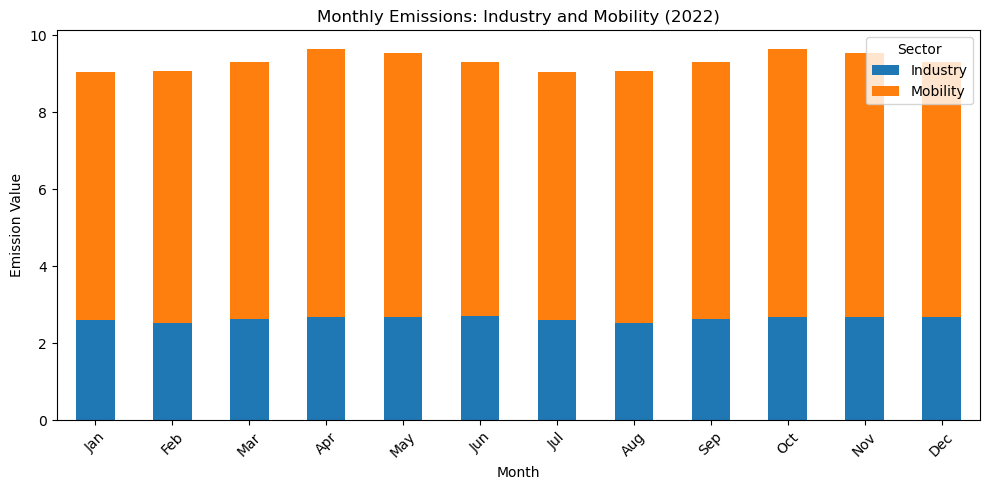

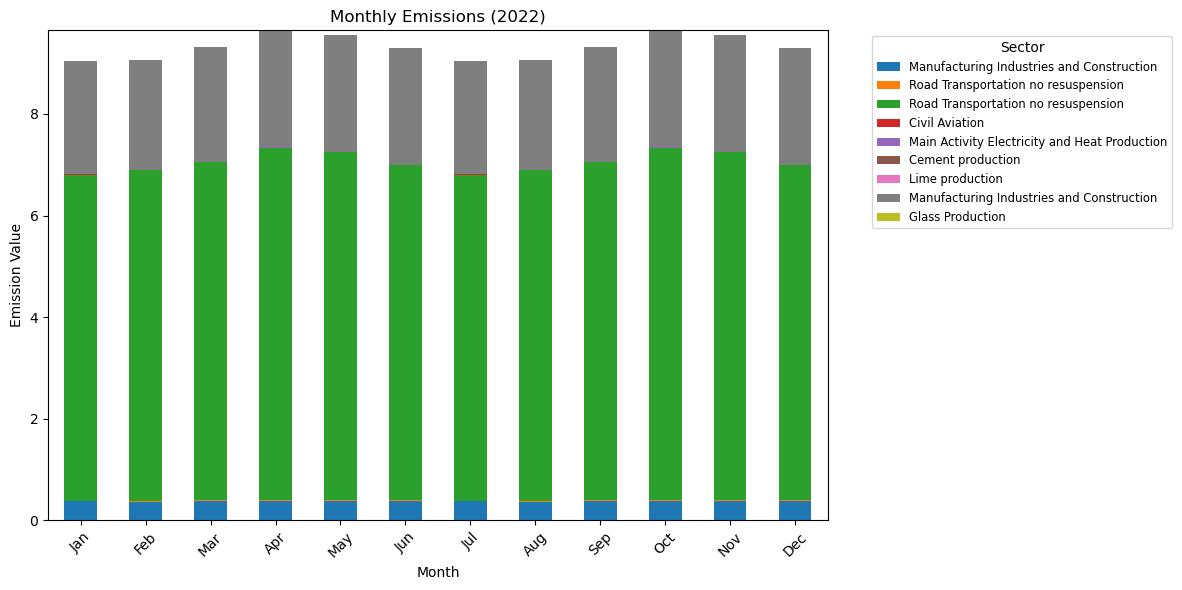

In [13]:
# Separate into two DataFrames
df_ind_mob = df_eth_final[df_eth_final['Sector'].isin(['Industry', 'Mobility'])].set_index('Sector')
df_others = df_eth_final[~df_eth_final['Sector'].isin(['Industry', 'Mobility'])].set_index('Sector')

# Transpose for plotting
df_ind_mob_t = df_ind_mob.T
df_others_t = df_others.T

# Plot 1: Industry and Mobility
fig1, ax1 = plt.subplots(figsize=(10, 5))
df_ind_mob_t.plot(kind='bar', stacked=True, ax=ax1)
ax1.set_title('Monthly Emissions: Industry and Mobility (2022)')
ax1.set_ylabel('Emission Value')
ax1.set_xlabel('Month')
ax1.legend(title='Sector', loc='upper right')
plt.xticks(rotation=45)
plt.tight_layout()

# Plot 2: All other sectors
fig2, ax2 = plt.subplots(figsize=(12, 6))
df_others_t.plot(kind='bar', stacked=True, ax=ax2)
ax2.set_title('Monthly Emissions (2022)')
ax2.set_ylabel('Emission Value')
ax2.set_xlabel('Month')
ax2.legend(title='Sector', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

#### Iraq

In [14]:
# Display the first few rows of the DataFrame
df_irq

,IPCC_annex,C_group_IM24_sh,Country_code_A3,Name,ipcc_code_2006_for_standard_report,ipcc_code_2006_for_standard_report_name,fossil_bio,Substance,Year,Jan,...,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,Non-Annex_I,Middle_East,IRQ,Iraq,3.C.1,Emissions from biomass burning,bio,NOx,2000,0.010404,...,0.094832,0.128308,0.079952,0.058536,0.052639,0.070980,0.152705,0.212117,0.143252,0.045216
1,Non-Annex_I,Middle_East,IRQ,Iraq,1.B.1,Solid Fuels,bio,NOx,2000,0.000425,...,0.000357,0.000349,0.000302,0.000271,0.000264,0.000257,0.000279,0.000333,0.000370,0.000404
2,Non-Annex_I,Middle_East,IRQ,Iraq,1.A.5,Non-Specified,bio,NOx,2000,0.015233,...,0.007302,0.001089,0.000335,0.000048,0.000004,0.000008,0.000071,0.000946,0.005081,0.011644
3,Non-Annex_I,Middle_East,IRQ,Iraq,1.A.1.bc,Petroleum Refining - Manufacture of Solid Fuel...,fossil,NOx,2000,0.940446,...,0.940446,0.940446,0.940446,0.940446,0.940446,0.940446,0.940446,0.940446,0.940446,0.940897
4,Non-Annex_I,Middle_East,IRQ,Iraq,1.B.2,Oil and Natural Gas,fossil,NOx,2000,0.660570,...,0.660570,0.660570,0.660570,0.660570,0.660570,0.660570,0.660570,0.660570,0.660570,0.660887
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
353,Non-Annex_I,Middle_East,IRQ,Iraq,2.B,Chemical Industry,fossil,NOx,2022,0.008387,...,0.008659,0.008402,0.008103,0.008021,0.007545,0.007032,0.007492,0.008142,0.008345,0.008521
354,Non-Annex_I,Middle_East,IRQ,Iraq,2.A.1,Cement production,fossil,NOx,2022,0.003320,...,0.003414,0.003355,0.003260,0.003239,0.003067,0.002884,0.003052,0.003274,0.003330,0.003391
355,Non-Annex_I,Middle_East,IRQ,Iraq,3.A.2,Manure Management,fossil,NOx,2022,0.038386,...,0.038386,0.038386,0.038386,0.038386,0.038386,0.038386,0.038386,0.038386,0.038386,0.038404
356,Non-Annex_I,Middle_East,IRQ,Iraq,1.B.2,Oil and Natural Gas,fossil,NOx,2022,1.686552,...,1.686552,1.686552,1.686552,1.686552,1.686552,1.686552,1.686552,1.686552,1.686552,1.687362


In [15]:
## select the variables of interest
df_irq_select = df_irq[df_irq['ipcc_code_2006_for_standard_report_name'].isin(industry + mobility)]
# Select the 'Year' column and filter for the year 2022
df_irq_select = df_irq_select[df_irq_select['Year'] == 2022]
df_irq_select

,IPCC_annex,C_group_IM24_sh,Country_code_A3,Name,ipcc_code_2006_for_standard_report,ipcc_code_2006_for_standard_report_name,fossil_bio,Substance,Year,Jan,...,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
345,Non-Annex_I,Middle_East,IRQ,Iraq,1.A.3.a,Civil Aviation,fossil,NOx,2022,0.033336,...,0.033336,0.033336,0.033336,0.033336,0.033336,0.033336,0.033336,0.033336,0.033336,0.033352
346,Non-Annex_I,Middle_East,IRQ,Iraq,2.A.3,Glass Production,fossil,NOx,2022,0.000006,...,0.000006,0.000006,0.000006,0.000005,0.000005,0.000005,0.000005,0.000006,0.000006,0.000006
347,Non-Annex_I,Middle_East,IRQ,Iraq,2.A.2,Lime production,fossil,NOx,2022,0.000007,...,0.000007,0.000007,0.000007,0.000007,0.000007,0.000006,0.000007,0.000007,0.000007,0.000007
348,Non-Annex_I,Middle_East,IRQ,Iraq,1.A.1.a,Main Activity Electricity and Heat Production,fossil,NOx,2022,57.320738,...,8.459095,7.355889,7.817153,8.013230,9.223397,8.807607,8.331852,9.387850,10.100229,8.469228
352,Non-Annex_I,Middle_East,IRQ,Iraq,1.A.2,Manufacturing Industries and Construction,fossil,NOx,2022,3.161885,...,3.271743,3.153882,3.030928,2.992005,2.807573,2.593313,2.769741,3.042205,3.131692,3.203719
354,Non-Annex_I,Middle_East,IRQ,Iraq,2.A.1,Cement production,fossil,NOx,2022,0.003320,...,0.003414,0.003355,0.003260,0.003239,0.003067,0.002884,0.003052,0.003274,0.003330,0.003391
357,Non-Annex_I,Middle_East,IRQ,Iraq,1.A.3.b_noRES,Road Transportation no resuspension,fossil,NOx,2022,12.676888,...,13.634860,14.194649,14.324600,14.186319,14.049704,14.071362,14.174657,14.707789,14.227970,13.298320


In [16]:
## Only contain the columns of interest
df_irq_select = df_irq_select[['ipcc_code_2006_for_standard_report_name', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']]
df_irq_select = df_irq_select.rename(columns={'ipcc_code_2006_for_standard_report_name': 'Sector'})
df_irq_select

,Sector,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
345,Civil Aviation,0.033336,0.033336,0.033336,0.033336,0.033336,0.033336,0.033336,0.033336,0.033336,0.033336,0.033336,0.033352
346,Glass Production,0.000006,0.000006,0.000006,0.000006,0.000006,0.000005,0.000005,0.000005,0.000005,0.000006,0.000006,0.000006
347,Lime production,0.000007,0.000007,0.000007,0.000007,0.000007,0.000007,0.000007,0.000006,0.000007,0.000007,0.000007,0.000007
348,Main Activity Electricity and Heat Production,57.320738,27.772251,8.459095,7.355889,7.817153,8.013230,9.223397,8.807607,8.331852,9.387850,10.100229,8.469228
352,Manufacturing Industries and Construction,3.161885,3.218269,3.271743,3.153882,3.030928,2.992005,2.807573,2.593313,2.769741,3.042205,3.131692,3.203719
354,Cement production,0.003320,0.003333,0.003414,0.003355,0.003260,0.003239,0.003067,0.002884,0.003052,0.003274,0.003330,0.003391
357,Road Transportation no resuspension,12.676888,13.056745,13.634860,14.194649,14.324600,14.186319,14.049704,14.071362,14.174657,14.707789,14.227970,13.298320


In [17]:
# Create masks based on the industry and mobility lists
industry_mask = df_irq_select['Sector'].str.contains('|'.join(industry), case=False, na=False)
mobility_mask = df_irq_select['Sector'].str.contains('|'.join(mobility), case=False, na=False)

# Calculate monthly sums for each group
industry_sum = df_irq_select[industry_mask].iloc[:, 1:].sum()
mobility_sum = df_irq_select[mobility_mask].iloc[:, 1:].sum()

# Create new rows
industry_row = pd.DataFrame([['Industry'] + list(industry_sum)], columns=df_irq_select.columns)
mobility_row = pd.DataFrame([['Mobility'] + list(mobility_sum)], columns=df_irq_select.columns)

# Append to original DataFrame
df_irq_final = pd.concat([df_irq_select, industry_row, mobility_row], ignore_index=True)
df_irq_final

,Sector,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,Civil Aviation,0.033336,0.033336,0.033336,0.033336,0.033336,0.033336,0.033336,0.033336,0.033336,0.033336,0.033336,0.033352
1,Glass Production,0.000006,0.000006,0.000006,0.000006,0.000006,0.000005,0.000005,0.000005,0.000005,0.000006,0.000006,0.000006
2,Lime production,0.000007,0.000007,0.000007,0.000007,0.000007,0.000007,0.000007,0.000006,0.000007,0.000007,0.000007,0.000007
3,Main Activity Electricity and Heat Production,57.320738,27.772251,8.459095,7.355889,7.817153,8.013230,9.223397,8.807607,8.331852,9.387850,10.100229,8.469228
4,Manufacturing Industries and Construction,3.161885,3.218269,3.271743,3.153882,3.030928,2.992005,2.807573,2.593313,2.769741,3.042205,3.131692,3.203719
5,Cement production,0.003320,0.003333,0.003414,0.003355,0.003260,0.003239,0.003067,0.002884,0.003052,0.003274,0.003330,0.003391
6,Road Transportation no resuspension,12.676888,13.056745,13.634860,14.194649,14.324600,14.186319,14.049704,14.071362,14.174657,14.707789,14.227970,13.298320
7,Industry,60.485955,30.993866,11.734265,10.513139,10.851354,11.008486,12.034050,11.403816,11.104656,12.433342,13.235264,11.676350
8,Mobility,12.710224,13.090081,13.668196,14.227985,14.357936,14.219655,14.083040,14.104698,14.207993,14.741125,14.261306,13.331672


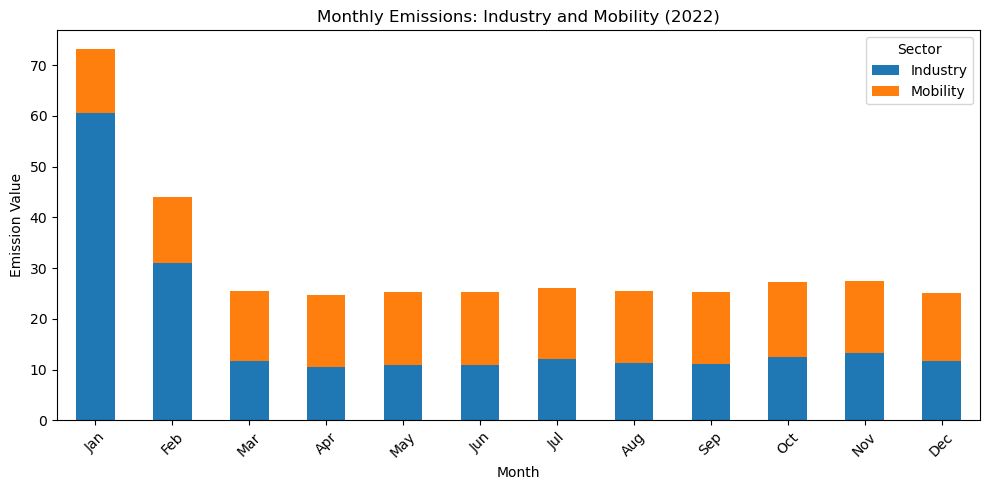

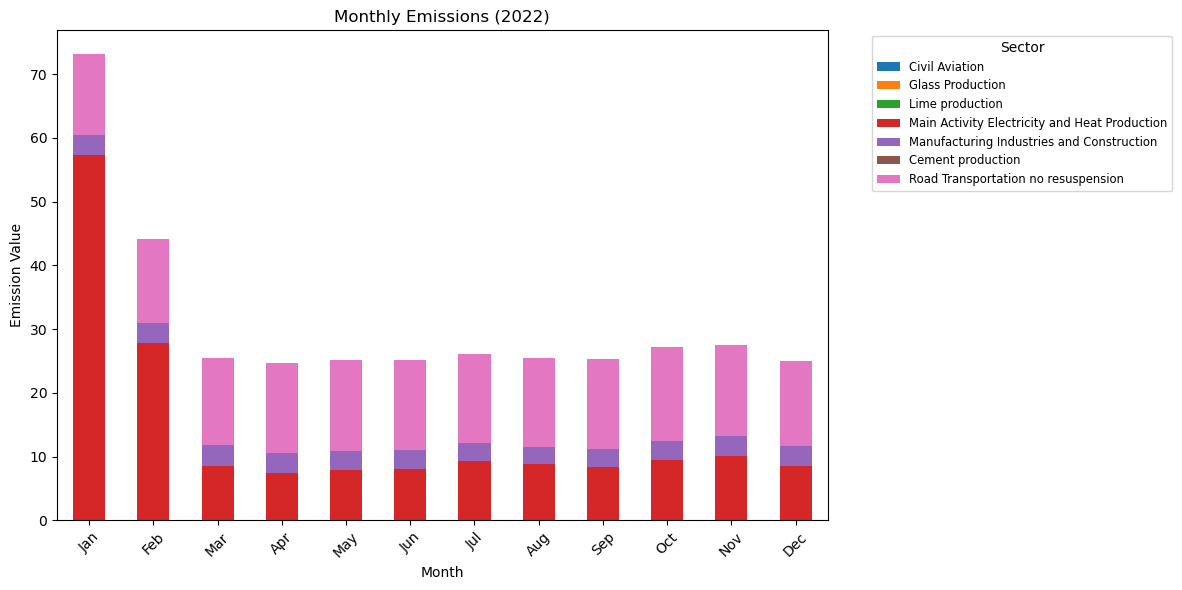

In [18]:
# Separate into two DataFrames
df_ind_mob = df_irq_final[df_irq_final['Sector'].isin(['Industry', 'Mobility'])].set_index('Sector')
df_others = df_irq_final[~df_irq_final['Sector'].isin(['Industry', 'Mobility'])].set_index('Sector')

# Transpose for plotting
df_ind_mob_t = df_ind_mob.T
df_others_t = df_others.T

# Plot 1: Industry and Mobility
fig1, ax1 = plt.subplots(figsize=(10, 5))
df_ind_mob_t.plot(kind='bar', stacked=True, ax=ax1)
ax1.set_title('Monthly Emissions: Industry and Mobility (2022)')
ax1.set_ylabel('Emission Value')
ax1.set_xlabel('Month')
ax1.legend(title='Sector', loc='upper right')
plt.xticks(rotation=45)
plt.tight_layout()

# Plot 2: All other sectors
fig2, ax2 = plt.subplots(figsize=(12, 6))
df_others_t.plot(kind='bar', stacked=True, ax=ax2)
ax2.set_title('Monthly Emissions (2022)')
ax2.set_ylabel('Emission Value')
ax2.set_xlabel('Month')
ax2.legend(title='Sector', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

In [3]:
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:

# Import customised scripts
from aggregation import*
from missingvalue import*
from visualization import*

# print(REPO_PATH)

Visualise elasticity

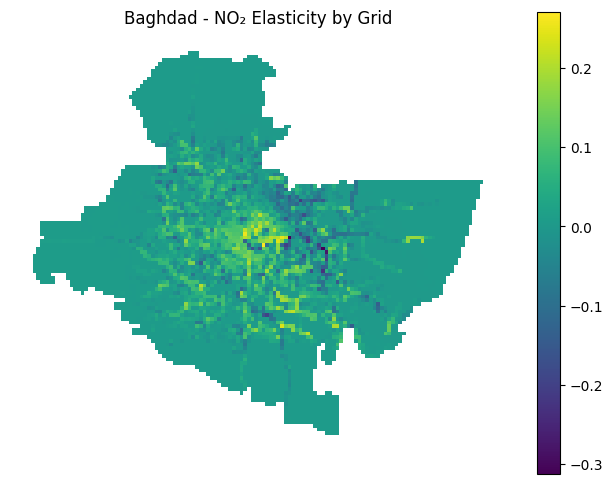

<Axes: title={'center': 'Baghdad - NO₂ Elasticity by Grid'}>

In [ ]:
gpkg_files = DATA_PATH/'baghdad-empty-mesh-data-20250616T170728Z-1-001/baghdad-empty-mesh-data/baghdad-2023-01-01.gpkg'
gpkg_path = gpkg_files[0]
layer_name = fiona.listlayers(gpkg_path)[0] 

features = []
with fiona.open(gpkg_path, layer=layer_name) as src:
    for rec in src:
        try:
            coords = rec["geometry"]["coordinates"]
            poly = Polygon(coords[0])  # use only exterior ring
            feature = {**rec["properties"], "geometry": poly}
            features.append(feature)
        except Exception:
            continue

gdf = gpd.GeoDataFrame(features, geometry="geometry")

# Load Excel with NO2 elasticity
excel_path = DATA_PATH/'slope_tableamy.xlsx'
df = pd.read_excel(excel_path)

#Aggregate elasticity by grid id
df_agg = df.groupby("geom_id").agg(no2_elasticity=("no2_elasticity", "mean")).reset_index()

# Merge onto spatial grid
gdf_merged = gdf.merge(df_agg, on="geom_id", how="left")


plot_mesh(
    mesh    = gdf_merged,
    feature = "no2_elasticity",
    title   = "Baghdad - NO₂ Elasticity by Grid",
    show_edges=False
)


### 2.3 Link Cell to Corresponding Sub-administrative Area

Addis Ababa

In [14]:
BOUNDARY_PATH = DATA_PATH / "boundary-data"

import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
admin_gdf = gpd.read_file(BOUNDARY_PATH / "addis-ababa-boundary" / "addis-ababa-adm3.shp")
mesh_gdf = gpd.read_file(DATA_PATH / 'mesh-grid' / 'grid_addis_ababa.gpkg')

if admin_gdf.crs != mesh_gdf.crs:
    admin_gdf = admin_gdf.to_crs(mesh_gdf.crs)

joined = gpd.sjoin(mesh_gdf, admin_gdf, how="left", predicate="intersects") # predicate="intersects" if two cell area intersect,join together
joined_unique = joined.drop_duplicates(subset='geom_id', keep='first')      # only save the first appearance
result = joined_unique[['geom_id', 'Shape_Leng', 'Shape_Area', 'ADM3_EN', 'ADM3_PCODE', 'geometry']]

result.to_file(DATA_PATH / 'mesh-grid' / "addis_mesh_with_admin3.gpkg")

In [18]:
# Write the results to the parquet
full_addis_df = pd.read_parquet(DATA_PATH / "temp" / "full_addis_df.parquet", engine="pyarrow")
addis_mesh_admin = gpd.read_file(DATA_PATH / 'mesh-grid' / 'addis_mesh_with_admin3.gpkg')
full_addis_df = full_addis_df.merge(addis_mesh_admin, on='geom_id')

# # Save the file
df_no_geometry = full_addis_df.drop(columns=[col for col in full_addis_df.columns if "geometry_y" in col])
df_no_geometry.to_parquet(DATA_PATH / "temp" / "full_addis_df.parquet", engine="pyarrow", compression="snappy")

Baghdad

In [19]:
import geopandas as gpd
from shapely.geometry import Point
admin_gdf = gpd.read_file(BOUNDARY_PATH / "baghdad-boundary" / "baghdad-adm3.shp")
mesh_gdf = gpd.read_file(DATA_PATH / 'mesh-grid' / 'grid_baghdad.gpkg')

if admin_gdf.crs != mesh_gdf.crs:
    admin_gdf = admin_gdf.to_crs(mesh_gdf.crs)

joined = gpd.sjoin(mesh_gdf, admin_gdf, how="left", predicate="intersects") # predicate="intersects" if two cell area intersect,join together
joined_unique = joined.drop_duplicates(subset='geom_id', keep='first')      # only save the first appearance
result = joined_unique[['geom_id', 'Shape_Leng', 'Shape_Area', 'ADM3_EN', 'ADM3_PCODE', 'geometry']]

result.to_file(DATA_PATH / 'mesh-grid' / "baghdad_mesh_with_admin3.gpkg")

In [20]:
# Write the results to the parquet
full_baghdad_df = pd.read_parquet(DATA_PATH / "temp" / "full_baghdad_df.parquet", engine="pyarrow")
baghdad_mesh_admin = gpd.read_file(DATA_PATH / 'mesh-grid' / 'baghdad_mesh_with_admin3.gpkg')
full_baghdad_df = full_baghdad_df.merge(baghdad_mesh_admin, on='geom_id')

# # Save the file
df_no_geometry = full_baghdad_df.drop(columns=[col for col in full_baghdad_df.columns if "geometry_y" in col])
df_no_geometry.to_parquet(DATA_PATH / "temp" / "full_baghdad_df.parquet", engine="pyarrow", compression="snappy")